# 数据由星巴克提供，用来模拟他们的顾客和交易，探索不同群体对哪种优惠类型反应最好

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')


from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from matplotlib.colors import ListedColormap
from sklearn import metrics

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix


import string

import warnings
warnings.filterwarnings("ignore")

# 1. 数据导入

In [2]:
data_portfolio = pd.read_csv('Starbucks Customer Segmentation/portfolio.csv', index_col=0)
data_profile= pd.read_csv('Starbucks Customer Segmentation/profile.csv', index_col=0)
data_transcript = pd.read_csv('Starbucks Customer Segmentation/transcript.csv', index_col=0)

## 1.1 数据集初步观察

In [3]:
data_portfolio.head(2)

,reward,channels,difficulty,duration,offer_type,id
0,10,"['email', 'mobile', 'social']",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"['web', 'email', 'mobile', 'social']",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0


In [4]:
data_profile.head(2)

,gender,age,id,became_member_on,income
0,NaN,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0


In [5]:
data_transcript.head(2)

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0


### 原始数据
portfolio.csv - 发送给顾客的优惠数据（10个优惠; 6列）  
profile.csv - 客户的人口统计学数据（17,000名客户; 5列）  
transcript.csv - 客户对报价和交易的反应（306,648个事件; 4列）

1. 商家优惠：本次活动，星巴克一共推出了十种不同的优惠方案；十种方案有不同的推荐渠道、持续时间、奖励、获取难度等
3. 顾客：共有17000名客户参与，包含性别、年龄、会员ID、成为会员的日期和收入
3. 活动记录：活动期间，每位参与者收到的优惠方式和数量均不相同,总共约30W条活动记录

In [6]:
# 对数据集进行 更明显的改名
data_offer = data_portfolio
data_customer = data_profile

# 2 数据清洗

## 2.1 检查缺失值

In [7]:
print('data_offer: ' + '\n' + str(data_offer.isnull().sum()))
print('\ndata_customer: ' + '\n' + str(data_customer.isnull().sum()))
print('\ndata_transcript: ' + '\n' + str(data_transcript.isnull().sum()))

data_offer: 
reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64

data_customer: 
gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

data_transcript: 
person    0
event     0
value     0
time      0
dtype: int64


In [8]:
# 检查data_customer缺失值的具体情况
data_customer[data_customer['gender'].isnull()]

,gender,age,id,became_member_on,income
0,NaN,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
2,NaN,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
4,NaN,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
6,NaN,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,NaN,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN
...,...,...,...,...,...
16980,NaN,118,5c686d09ca4d475a8f750f2ba07e0440,20160901,NaN
16982,NaN,118,d9ca82f550ac4ee58b6299cf1e5c824a,20160415,NaN
16989,NaN,118,ca45ee1883624304bac1e4c8a114f045,20180305,NaN
16991,NaN,118,a9a20fa8b5504360beb4e7c8712f8306,20160116,NaN


### 通过观察，发现gender和income的缺失值似乎总是一起出现，且年龄为118

In [9]:
# 验证两者缺失值之间的关系
missing_num = (data_customer[data_customer['gender'].isnull()]['id'] == data_customer[data_customer['income'].isnull()]['id']).sum()
missing_num

2175

In [10]:
data_customer[data_customer['gender'].isnull()]['age'].value_counts()

age
118    2175
Name: count, dtype: int64

In [11]:
# 测算缺失比例
'Missing Number percentage: {:.2%}'.format(missing_num / len(data_customer))

'Missing Number percentage: 12.79%'

### 根据现有特征，无法较为准确的填充缺失值，为了避免误导数据集结果，直接删除缺失值

In [12]:
removed_id = data_customer[data_customer['gender'].isnull()]['id']

drop_row = data_customer[data_customer['gender'].isnull()].index

data_customer.drop(drop_row, inplace=True)

# 重置index
data_customer.reset_index()

data_customer.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14825 entries, 1 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               14825 non-null  int64  
 2   id                14825 non-null  object 
 3   became_member_on  14825 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 694.9+ KB


# 3 数据预处理

## 3.1 data_customer
1. became_member_on转换为DateTime
2. gender 转换为数值列
3. id 重命名为顾客id

In [13]:
# became_member_on转换为DateTime
data_customer['became_member_date'] = pd.to_datetime(data_customer['became_member_on'], format='%Y%m%d')
data_customer.drop('became_member_on', axis=1, inplace=True)

data_customer.head(2)

,gender,age,id,income,became_member_date
1,F,55,0610b486422d4921ae7d2bf64640c50b,112000.0,2017-07-15
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017-05-09


In [14]:
# became_member_date增添特征列，年月日
data_customer = data_customer.assign(member_year = data_customer.became_member_date.dt.year,
                                      member_month = data_customer.became_member_date.dt.month,
                                      member_day = data_customer.became_member_date.dt.day,
                                      member_day_of_week = data_customer.became_member_date.dt.weekday)

data_customer

,gender,age,id,income,became_member_date,member_year,member_month,member_day,member_day_of_week
1,F,55,0610b486422d4921ae7d2bf64640c50b,112000.0,2017-07-15,2017,7,15,5
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017-05-09,2017,5,9,1
5,M,68,e2127556f4f64592b11af22de27a7932,70000.0,2018-04-26,2018,4,26,3
8,M,65,389bc3fa690240e798340f5a15918d5c,53000.0,2018-02-09,2018,2,9,4
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2017-11-11,2017,11,11,5
...,...,...,...,...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,54000.0,2018-06-04,2018,6,4,0
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,72000.0,2018-07-13,2018,7,13,4
16997,M,49,01d26f638c274aa0b965d24cefe3183f,73000.0,2017-01-26,2017,1,26,3
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,50000.0,2016-03-07,2016,3,7,0


In [15]:
# 重命名顾客id
data_customer.rename(columns={"id": "customer_id"}, inplace=True)
data_customer.head(2)

,gender,age,customer_id,income,became_member_date,member_year,member_month,member_day,member_day_of_week
1,F,55,0610b486422d4921ae7d2bf64640c50b,112000.0,2017-07-15,2017,7,15,5
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017-05-09,2017,5,9,1


In [16]:
# gender 转换为数值列
data_customer.gender.value_counts()

gender
M    8484
F    6129
O     212
Name: count, dtype: int64

In [17]:
# gender 独热编码，指定为int类型
data_customer = data_customer.join(pd.get_dummies(data_customer.gender, dtype=int, prefix='gender'))

data_customer

,gender,age,customer_id,income,became_member_date,member_year,member_month,member_day,member_day_of_week,gender_F,gender_M,gender_O
1,F,55,0610b486422d4921ae7d2bf64640c50b,112000.0,2017-07-15,2017,7,15,5,1,0,0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017-05-09,2017,5,9,1,1,0,0
5,M,68,e2127556f4f64592b11af22de27a7932,70000.0,2018-04-26,2018,4,26,3,0,1,0
8,M,65,389bc3fa690240e798340f5a15918d5c,53000.0,2018-02-09,2018,2,9,4,0,1,0
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2017-11-11,2017,11,11,5,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,54000.0,2018-06-04,2018,6,4,0,1,0,0
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,72000.0,2018-07-13,2018,7,13,4,0,1,0
16997,M,49,01d26f638c274aa0b965d24cefe3183f,73000.0,2017-01-26,2017,1,26,3,0,1,0
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,50000.0,2016-03-07,2016,3,7,0,1,0,0


In [18]:
data_customer.drop('became_member_date', axis=1, inplace=True)

data_customer.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14825 entries, 1 to 16999
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              14825 non-null  object 
 1   age                 14825 non-null  int64  
 2   customer_id         14825 non-null  object 
 3   income              14825 non-null  float64
 4   member_year         14825 non-null  int32  
 5   member_month        14825 non-null  int32  
 6   member_day          14825 non-null  int32  
 7   member_day_of_week  14825 non-null  int32  
 8   gender_F            14825 non-null  int32  
 9   gender_M            14825 non-null  int32  
 10  gender_O            14825 non-null  int32  
dtypes: float64(1), int32(7), int64(1), object(2)
memory usage: 1.5+ MB


In [19]:
data_customer.columns

Index(['gender', 'age', 'customer_id', 'income', 'member_year', 'member_month',
       'member_day', 'member_day_of_week', 'gender_F', 'gender_M', 'gender_O'],
      dtype='object')

In [20]:
data_customer = data_customer[['customer_id', 'gender', 'age', 'income', 'gender_F', 'gender_M', 'gender_O', 
                               'member_year', 'member_month','member_day', 'member_day_of_week']]

data_customer.head(3)

,customer_id,gender,age,income,gender_F,gender_M,gender_O,member_year,member_month,member_day,member_day_of_week
1,0610b486422d4921ae7d2bf64640c50b,F,55,112000.0,1,0,0,2017,7,15,5
3,78afa995795e4d85b5d9ceeca43f5fef,F,75,100000.0,1,0,0,2017,5,9,1
5,e2127556f4f64592b11af22de27a7932,M,68,70000.0,0,1,0,2018,4,26,3


## 3.2 data_offer
1. id重命名为offer_id，且重新构建一列易于观察的offer_id列
2. channels编码
3. offer_type编码

In [21]:
# 重命名活动id
data_offer.rename(columns={"id": "offer_id"}, inplace=True)

data_offer

,reward,channels,difficulty,duration,offer_type,offer_id
0,10,"['email', 'mobile', 'social']",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"['web', 'email', 'mobile', 'social']",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"['web', 'email', 'mobile']",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"['web', 'email', 'mobile']",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"['web', 'email']",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"['web', 'email', 'mobile', 'social']",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"['web', 'email', 'mobile', 'social']",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"['email', 'mobile', 'social']",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"['web', 'email', 'mobile', 'social']",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"['web', 'email', 'mobile']",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [22]:
# 创建推送途径特征转换函数
def split_channels(channels_list):
    if channel in channels_list:
        return 1
    else:
        return 0

# 将推送途径转换为特征列
all_channels = ['web', 'email', 'mobile', 'social']

for channel in all_channels:
    data_offer.loc[:, channel] = data_offer.channels.apply(split_channels)
    
data_offer

,reward,channels,difficulty,duration,offer_type,offer_id,web,email,mobile,social
0,10,"['email', 'mobile', 'social']",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1
1,10,"['web', 'email', 'mobile', 'social']",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,"['web', 'email', 'mobile']",0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,1,0
3,5,"['web', 'email', 'mobile']",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0
4,5,"['web', 'email']",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0
5,3,"['web', 'email', 'mobile', 'social']",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1
6,2,"['web', 'email', 'mobile', 'social']",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1
7,0,"['email', 'mobile', 'social']",0,3,informational,5a8bc65990b245e5a138643cd4eb9837,0,1,1,1
8,5,"['web', 'email', 'mobile', 'social']",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1
9,2,"['web', 'email', 'mobile']",10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,1,0


In [23]:
# 建推送活动类型转换函数
def split_offer_type(val):
    if val == offer:
        return 1
    else:
        return 0

offer_type = data_offer.offer_type.unique()

for offer in offer_type:
        data_offer[offer] = data_offer.offer_type.apply(split_offer_type)
        
data_offer

,reward,channels,difficulty,duration,offer_type,offer_id,web,email,mobile,social,bogo,informational,discount
0,10,"['email', 'mobile', 'social']",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1,1,0,0
1,10,"['web', 'email', 'mobile', 'social']",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
2,0,"['web', 'email', 'mobile']",0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,1,0,0,1,0
3,5,"['web', 'email', 'mobile']",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0,1,0,0
4,5,"['web', 'email']",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0,0,0,1
5,3,"['web', 'email', 'mobile', 'social']",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,0,0,1
6,2,"['web', 'email', 'mobile', 'social']",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,0,0,1
7,0,"['email', 'mobile', 'social']",0,3,informational,5a8bc65990b245e5a138643cd4eb9837,0,1,1,1,0,1,0
8,5,"['web', 'email', 'mobile', 'social']",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,1,0,0
9,2,"['web', 'email', 'mobile']",10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,1,0,0,0,1


In [24]:
data_offer

,reward,channels,difficulty,duration,offer_type,offer_id,web,email,mobile,social,bogo,informational,discount
0,10,"['email', 'mobile', 'social']",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1,1,0,0
1,10,"['web', 'email', 'mobile', 'social']",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
2,0,"['web', 'email', 'mobile']",0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,1,0,0,1,0
3,5,"['web', 'email', 'mobile']",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0,1,0,0
4,5,"['web', 'email']",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0,0,0,1
5,3,"['web', 'email', 'mobile', 'social']",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,0,0,1
6,2,"['web', 'email', 'mobile', 'social']",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,0,0,1
7,0,"['email', 'mobile', 'social']",0,3,informational,5a8bc65990b245e5a138643cd4eb9837,0,1,1,1,0,1,0
8,5,"['web', 'email', 'mobile', 'social']",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,1,0,0
9,2,"['web', 'email', 'mobile']",10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,1,0,0,0,1


In [25]:
data_offer.drop(['channels', 'offer_type'], axis=1, inplace=True)

data_offer

,reward,difficulty,duration,offer_id,web,email,mobile,social,bogo,informational,discount
0,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1,1,0,0
1,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
2,0,0,4,3f207df678b143eea3cee63160fa8bed,1,1,1,0,0,1,0
3,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0,1,0,0
4,5,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0,0,0,1
5,3,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,0,0,1
6,2,10,10,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,0,0,1
7,0,0,3,5a8bc65990b245e5a138643cd4eb9837,0,1,1,1,0,1,0
8,5,5,5,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,1,0,0
9,2,10,7,2906b810c7d4411798c6938adc9daaa5,1,1,1,0,0,0,1


In [26]:
# 按照优惠类型、难易程度、持续时间进行重新排序
data_offer = data_offer.sort_values(['reward', 'difficulty', 'duration']).reset_index(drop=True)

# 增添offer_id
column_labels = list(string.ascii_uppercase)[:10]

data_offer['offer_name'] = column_labels
    
data_offer

,reward,difficulty,duration,offer_id,web,email,mobile,social,bogo,informational,discount,offer_name
0,0,0,3,5a8bc65990b245e5a138643cd4eb9837,0,1,1,1,0,1,0,A
1,0,0,4,3f207df678b143eea3cee63160fa8bed,1,1,1,0,0,1,0,B
2,2,10,7,2906b810c7d4411798c6938adc9daaa5,1,1,1,0,0,0,1,C
3,2,10,10,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,0,0,1,D
4,3,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,0,0,1,E
5,5,5,5,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,1,0,0,F
6,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0,1,0,0,G
7,5,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0,0,0,1,H
8,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0,I
9,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1,1,0,0,J


In [27]:
data_offer.columns

Index(['reward', 'difficulty', 'duration', 'offer_id', 'web', 'email',
       'mobile', 'social', 'bogo', 'informational', 'discount', 'offer_name'],
      dtype='object')

In [28]:
data_offer = data_offer[['offer_id', 'offer_name', 'reward', 'difficulty', 'duration', 'web',
                         'email','mobile', 'social', 'bogo', 'informational', 'discount']]

data_offer

,offer_id,offer_name,reward,difficulty,duration,web,email,mobile,social,bogo,informational,discount
0,5a8bc65990b245e5a138643cd4eb9837,A,0,0,3,0,1,1,1,0,1,0
1,3f207df678b143eea3cee63160fa8bed,B,0,0,4,1,1,1,0,0,1,0
2,2906b810c7d4411798c6938adc9daaa5,C,2,10,7,1,1,1,0,0,0,1
3,fafdcd668e3743c1bb461111dcafc2a4,D,2,10,10,1,1,1,1,0,0,1
4,2298d6c36e964ae4a3e7e9706d1fb8c2,E,3,7,7,1,1,1,1,0,0,1
5,f19421c1d4aa40978ebb69ca19b0e20d,F,5,5,5,1,1,1,1,1,0,0
6,9b98b8c7a33c4b65b9aebfe6a799e6d9,G,5,5,7,1,1,1,0,1,0,0
7,0b1e1539f2cc45b7b9fa7c272da2e1d7,H,5,20,10,1,1,0,0,0,0,1
8,4d5c57ea9a6940dd891ad53e9dbe8da0,I,10,10,5,1,1,1,1,1,0,0
9,ae264e3637204a6fb9bb56bc8210ddfd,J,10,10,7,0,1,1,1,1,0,0


In [29]:
data_offer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   offer_id       10 non-null     object
 1   offer_name     10 non-null     object
 2   reward         10 non-null     int64 
 3   difficulty     10 non-null     int64 
 4   duration       10 non-null     int64 
 5   web            10 non-null     int64 
 6   email          10 non-null     int64 
 7   mobile         10 non-null     int64 
 8   social         10 non-null     int64 
 9   bogo           10 non-null     int64 
 10  informational  10 non-null     int64 
 11  discount       10 non-null     int64 
dtypes: int64(10), object(2)
memory usage: 1.1+ KB


## 3.3 data_transcript
1. person重命名为customer_id
2. time列新创建以DAY为单位的列
3. value拆分列，并提取为offer id和amount
4. event编码

In [30]:
data_transcript

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714


In [31]:
# 重命名顾客id
data_transcript.rename(columns={"person": "customer_id"}, inplace=True)

data_transcript.head(3)

,customer_id,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0


In [32]:
# 重命名顾客id
data_transcript.rename(columns={"time": "hours_since_start"}, inplace=True)

# 新建特征列，代表活动进行的第几天
data_transcript = data_transcript.assign(day_since_start = 
                                         data_transcript['hours_since_start'] / 24).astype({'day_since_start':'int64'})

data_transcript.head(3)

,customer_id,event,value,hours_since_start,day_since_start
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,0


In [33]:
data_transcript.tail(3)

,customer_id,event,value,hours_since_start,day_since_start
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714,29
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714,29
306533,c02b10e8752c4d8e9b73f918558531f7,transaction,{'amount': 4.05},714,29


In [34]:
data_transcript.value

0         {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1         {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2         {'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3         {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4         {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
                                ...                       
306529                      {'amount': 1.5899999999999999}
306530                                    {'amount': 9.53}
306531                                    {'amount': 3.61}
306532                      {'amount': 3.5300000000000002}
306533                                    {'amount': 4.05}
Name: value, Length: 306534, dtype: object

In [35]:
import ast

# 将输入的字符串参数val转换成字典 函数
def string_to_dict(val):
    return ast.literal_eval(val)

# value列转换为字典
data_transcript.value = data_transcript.value.apply(string_to_dict)


keys = []

# 提取键名 函数
def get_keys(val):
    if list(val.keys()) not in keys:
        keys.append(list(val.keys()))

# value列提取键名
data_transcript.value.apply(get_keys)

# 展开为一维列表，检查
keys = [ item for elem in keys for item in elem]

keys

['offer id', 'amount', 'offer_id', 'reward']

In [36]:
# 将字典类型的列value拆分为多个新列，并提取特定键对应的值填充新列，特定键由keys[1:3]指定

# 拆分字典 函数
def split_key(val):
    # 获取字典中的第一个键，变量key的前两个字符
    if list(val.keys())[0].startswith(key[:2]):
        return list(val.values())[0]
    else:
        return 0

# 保留'amount', 'offer_id'两个特征
for key in keys[1:3]:
    data_transcript[key] = data_transcript.value.apply(split_key)
    
data_transcript

,customer_id,event,value,hours_since_start,day_since_start,amount,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,0,0.00,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0,0.00,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,0,0.00,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,0,0.00,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,0,0.00,4d5c57ea9a6940dd891ad53e9dbe8da0
...,...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714,29,1.59,0
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714,29,9.53,0
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714,29,3.61,0
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714,29,3.53,0


In [37]:
# 删除value列
data_transcript.drop('value', axis=1, inplace=True)

In [38]:
data_transcript.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In [39]:
# event编码
data_transcript = data_transcript.join(pd.get_dummies(data_transcript.event, columns=['event'], dtype=int))

data_transcript

,customer_id,event,hours_since_start,day_since_start,amount,offer_id,offer completed,offer received,offer viewed,transaction
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,0,0.00,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0,0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0,0.00,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0,0
2,e2127556f4f64592b11af22de27a7932,offer received,0,0,0.00,2906b810c7d4411798c6938adc9daaa5,0,1,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,0,0.00,fafdcd668e3743c1bb461111dcafc2a4,0,1,0,0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,0,0.00,4d5c57ea9a6940dd891ad53e9dbe8da0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,714,29,1.59,0,0,0,0,1
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,714,29,9.53,0,0,0,0,1
306531,a00058cf10334a308c68e7631c529907,transaction,714,29,3.61,0,0,0,0,1
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,714,29,3.53,0,0,0,0,1


### 筛选活动动态
1. event活动中必须同时包含'offer received', 'offer viewed', 'offer completed'才算是成功参加了活动

In [40]:
data_transcript.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In [41]:
offer_event = data_transcript[data_transcript.event != 'transaction']

offer_event

,customer_id,event,hours_since_start,day_since_start,amount,offer_id,offer completed,offer received,offer viewed,transaction
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0,0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0,0
2,e2127556f4f64592b11af22de27a7932,offer received,0,0,0.0,2906b810c7d4411798c6938adc9daaa5,0,1,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,0,0.0,fafdcd668e3743c1bb461111dcafc2a4,0,1,0,0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,0,0.0,4d5c57ea9a6940dd891ad53e9dbe8da0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
306497,a6f84f4e976f44508c358cc9aba6d2b3,offer completed,714,29,0.0,2298d6c36e964ae4a3e7e9706d1fb8c2,1,0,0,0
306506,b895c57e8cd047a8872ce02aa54759d6,offer completed,714,29,0.0,fafdcd668e3743c1bb461111dcafc2a4,1,0,0,0
306507,8dda575c2a1d44b9ac8e8b07b93d1f8e,offer viewed,714,29,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0,1,0
306509,8431c16f8e1d440880db371a68f82dd0,offer completed,714,29,0.0,fafdcd668e3743c1bb461111dcafc2a4,1,0,0,0


In [42]:
# 新建offer successful特征列

# 将customer_id和offer_id作为索引，event作为列，aggfunc='size'计算每个组合的数量，用0填充缺失值
offer_customer = offer_event.pivot_table(index=['customer_id','offer_id'],\
                 columns='event', aggfunc='size', fill_value=0)
offer_customer.reset_index(level=[0,1], inplace=True)

# 记录哪些客户成功完成了特定的推广活动
offer_customer['offer successful'] =\
    offer_customer['offer received'] * offer_customer['offer viewed'] * offer_customer['offer completed']

# 如果一行中的offer successful大于0，则表示该客户参与了推广活动
offer_customer['offer successful'] = offer_customer['offer successful'].apply(lambda x: 1 if x > 0 else 0)

offer_customer

event,customer_id,offer_id,offer completed,offer received,offer viewed,offer successful
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1,1,0,0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0,1,1,0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0,1,1,0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1
...,...,...,...,...,...,...
63283,fffad4f4828548d1b5583907f2e9906b,f19421c1d4aa40978ebb69ca19b0e20d,2,2,2,1
63284,ffff82501cea40309d5fdd7edcca4a07,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,1,1
63285,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,3,3,3,1
63286,ffff82501cea40309d5fdd7edcca4a07,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,1


## 3.4 创建完整数据表
将处理干净的数据集合并为全新完整的活动数据表

In [43]:
print('offer_customer' + str(offer_customer.shape))
print('data_offer' + str(data_offer.shape))
print('data_customer' + str(data_customer.shape))

offer_customer(63288, 6)
data_offer(10, 12)
data_customer(14825, 11)


In [44]:
offer_customer.head(3)

event,customer_id,offer_id,offer completed,offer received,offer viewed,offer successful
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1,1,0,0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0,1,1,0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0,1,1,0


In [45]:
data_offer.head(3)

,offer_id,offer_name,reward,difficulty,duration,web,email,mobile,social,bogo,informational,discount
0,5a8bc65990b245e5a138643cd4eb9837,A,0,0,3,0,1,1,1,0,1,0
1,3f207df678b143eea3cee63160fa8bed,B,0,0,4,1,1,1,0,0,1,0
2,2906b810c7d4411798c6938adc9daaa5,C,2,10,7,1,1,1,0,0,0,1


In [46]:
data_customer.head(3)

,customer_id,gender,age,income,gender_F,gender_M,gender_O,member_year,member_month,member_day,member_day_of_week
1,0610b486422d4921ae7d2bf64640c50b,F,55,112000.0,1,0,0,2017,7,15,5
3,78afa995795e4d85b5d9ceeca43f5fef,F,75,100000.0,1,0,0,2017,5,9,1
5,e2127556f4f64592b11af22de27a7932,M,68,70000.0,0,1,0,2018,4,26,3


In [47]:
# 合并数据集
data_overall = pd.merge(offer_customer, data_offer, on='offer_id', how='left')

data_overall = pd.merge(data_overall, data_customer, on='customer_id')


print('data_overall' + str(data_overall.shape))

data_overall.head()

data_overall(55222, 27)


,customer_id,offer_id,offer completed,offer received,offer viewed,offer successful,offer_name,reward,difficulty,duration,...,gender,age,income,gender_F,gender_M,gender_O,member_year,member_month,member_day,member_day_of_week
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1,1,0,0,C,2,10,7,...,M,33,72000.0,0,1,0,2017,4,21,4
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0,1,1,0,B,0,0,4,...,M,33,72000.0,0,1,0,2017,4,21,4
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0,1,1,0,A,0,0,3,...,M,33,72000.0,0,1,0,2017,4,21,4
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,F,5,5,5,...,M,33,72000.0,0,1,0,2017,4,21,4
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,D,2,10,10,...,M,33,72000.0,0,1,0,2017,4,21,4


In [48]:
# 检查重复值
data_overall.duplicated().sum()

0

# 存档


In [49]:
data_customer2 = data_customer.copy()
data_offer2 = data_offer.copy()
data_transcript2 = data_transcript.copy()
data_overall2 = data_overall.copy()

# 4 Exploratory Data Analysis (EDA)

## 4.1 客户特征 -- 单变量统计分析
探索客户的性别、年龄、薪资等对活动的影响

### 4.1.1 性别

In [50]:
data_customer2['gender'].value_counts()

gender
M    8484
F    6129
O     212
Name: count, dtype: int64

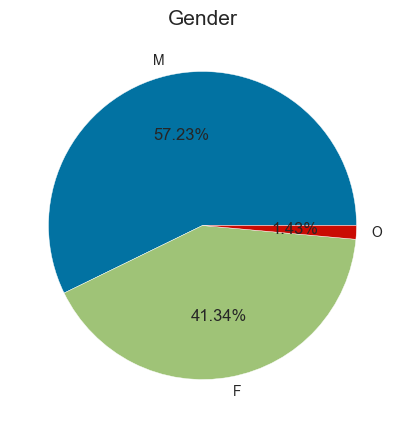

In [51]:
plt.figure(figsize = (5,5))

plt.pie(x=data_customer2['gender'].value_counts(), 
        labels=data_customer2['gender'].value_counts().index.tolist(), 
        autopct = '%1.2f%%')
plt.title('Gender', fontsize=15)

plt.show()

### 性别观察结论：
此次活动中，男性占比57.23%比女性41.34%多

### 4.1.2 年龄

In [52]:
data_customer2['age'].value_counts()

age
58     408
53     372
51     363
59     359
54     359
      ... 
100     12
96       8
98       5
101      5
99       5
Name: count, Length: 84, dtype: int64

In [53]:
data_customer2['age'].describe()

count    14825.000000
mean        54.393524
std         17.383705
min         18.000000
25%         42.000000
50%         55.000000
75%         66.000000
max        101.000000
Name: age, dtype: float64

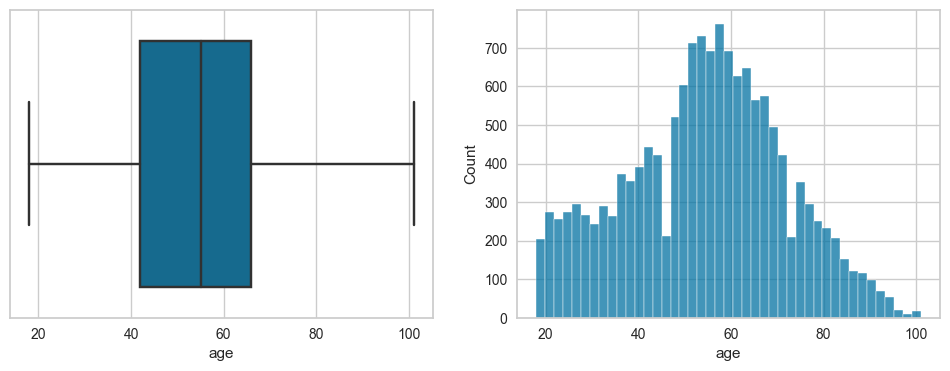

In [54]:
# 年龄可视化
fig, axs = plt.subplots(1,2, figsize=(12,4))

sns.boxplot(data=data_customer2, x='age', ax=axs[0])
sns.histplot(data=data_customer2, x='age', ax=axs[1])

plt.show()

#### 年龄数据符合正态分布，但是观察到有异常值

In [55]:
print('Min age: '+ str(min(data_customer2['age'])))
print('Max age: '+ str(max(data_customer2['age'])))

Min age: 18
Max age: 101


In [56]:
# 将年龄进行分组，可视化
age_group = pd.cut(data_customer2['age'],
                  bins = [data_customer2['age'].min(), 26, 36, 46, 56, 66, 76, data_customer2['age'].max()],
                  labels = ['18-25', '26-35', '36-45', '46-55', '56-65', '66-75', '>76'])

data_customer2['age_group'] = age_group

# 计算各个年龄组的占比
age_group_per = (data_customer2['age_group'].value_counts().sort_index() / data_customer2.shape[0] * 100).round(2)
age_group_per

age_group
18-25     7.41
26-35     9.31
36-45    13.62
46-55    22.00
56-65    22.21
66-75    14.89
>76      10.08
Name: count, dtype: float64

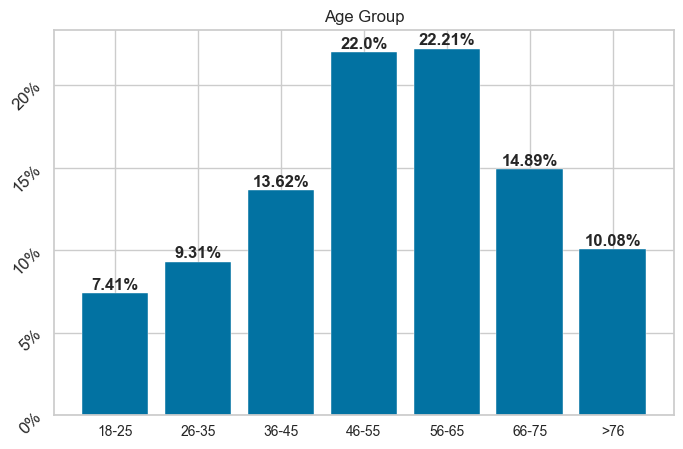

In [57]:
plt.figure(figsize=(8,5))

yticks = np.arange(0,25,5)
yticklabels = [str(y) + '%' for y in yticks]

plt.yticks(yticks, labels = yticklabels)
plt.yticks(rotation = 45, fontsize = 12)
plt.title('Age Group')

bar_plot = plt.bar(x = age_group_per.index.values, height = age_group_per)

for i, bar in enumerate(bar_plot.patches):
    x,y = bar.get_xy()
    plt.text(x+bar.get_width()/2, y+bar.get_height()+0.2,
            str(age_group_per[i]) + '%',
            ha = 'center',
            weight = 'bold')

### 年龄观察结论：
1. 第一梯队占比最多的年龄组为46-65岁，一共占据约50%，是这次优惠活动反应的主力
2. 第二梯队，年龄组为36-45和66-75，各占14%左右
3. 总体来说，年轻人的占比是最低的，说明他们对优惠活动的反应不大；中老年人对于优惠活动的参与度更高

### 4.1.3 收入分析

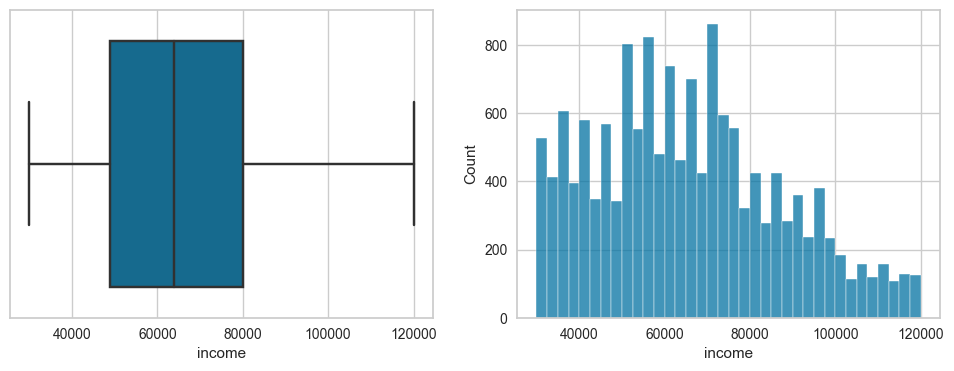

In [58]:
# 同样先观察收入的可视化基本情况
fig, axs = plt.subplots(1,2, figsize=(12,4))

sns.boxplot(data=data_customer2, x='income', ax=axs[0])
sns.histplot(data=data_customer2, x='income', ax=axs[1])

plt.show()

In [59]:
data_customer2['income'].describe()

count     14825.000000
mean      65404.991568
std       21598.299410
min       30000.000000
25%       49000.000000
50%       64000.000000
75%       80000.000000
max      120000.000000
Name: income, dtype: float64

In [60]:
print('收入众数为'+ str(data_customer2['income'].value_counts().tolist()[0])+ 
      '个人, \n收入为' +
      str(data_customer2['income'].mode().values[0]) + '元'
     )

收入众数为314个人, 
收入为73000.0元


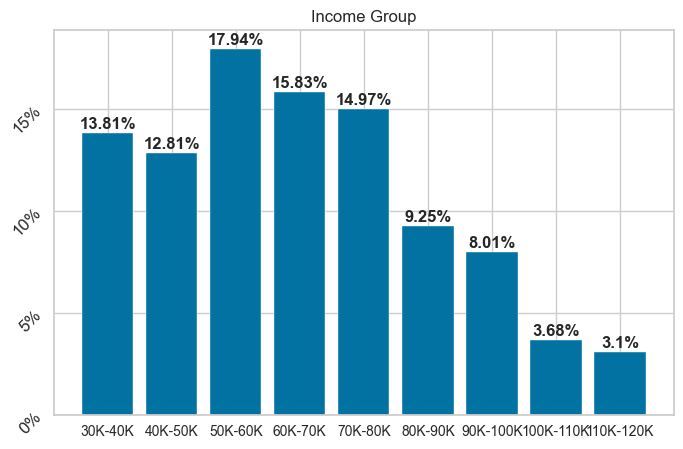

In [61]:
# 收入分组可视化
income_group = pd.cut(data_customer2['income'],
                  bins = [data_customer2['income'].min(), 40000, 50000, 60000, 70000, 80000, 90000, 100000, 110000, data_customer2['income'].max()],
                  labels = ['30K-40K', '40K-50K', '50K-60K', '60K-70K', '70K-80K', '80K-90K', '90K-100K', '100K-110K', '110K-120K'])

data_customer2['income_group'] = income_group

# 计算各个年龄组的占比
income_group_per = (data_customer2['income_group'].value_counts().sort_index() / data_customer2.shape[0] * 100).round(2)


# 可视化
plt.figure(figsize=(8,5))

yticks = np.arange(0,25,5)
yticklabels = [str(y) + '%' for y in yticks]

plt.yticks(yticks, labels = yticklabels)
plt.yticks(rotation = 45, fontsize = 12)
plt.title('Income Group')

bar_plot = plt.bar(x = income_group_per.index.values, height = income_group_per)

for i, bar in enumerate(bar_plot.patches):
    x,y = bar.get_xy()
    plt.text(x+bar.get_width()/2, y+bar.get_height()+0.2,
            str(income_group_per[i]) + '%',
            ha = 'center',
            weight = 'bold')

### 收入观察结果：
1. 客户收入范围在30K-120K，平均为65K
2. 收入极高的人对优惠活动的响应较低
3. 合理推测，收入极低或极高的人，都不是优惠活动的目标客群

### 4.1.4 成为会员时间的影响分析

In [62]:
data_customer2.head(3)

,customer_id,gender,age,income,gender_F,gender_M,gender_O,member_year,member_month,member_day,member_day_of_week,age_group,income_group
1,0610b486422d4921ae7d2bf64640c50b,F,55,112000.0,1,0,0,2017,7,15,5,46-55,110K-120K
3,78afa995795e4d85b5d9ceeca43f5fef,F,75,100000.0,1,0,0,2017,5,9,1,66-75,90K-100K
5,e2127556f4f64592b11af22de27a7932,M,68,70000.0,0,1,0,2018,4,26,3,66-75,60K-70K


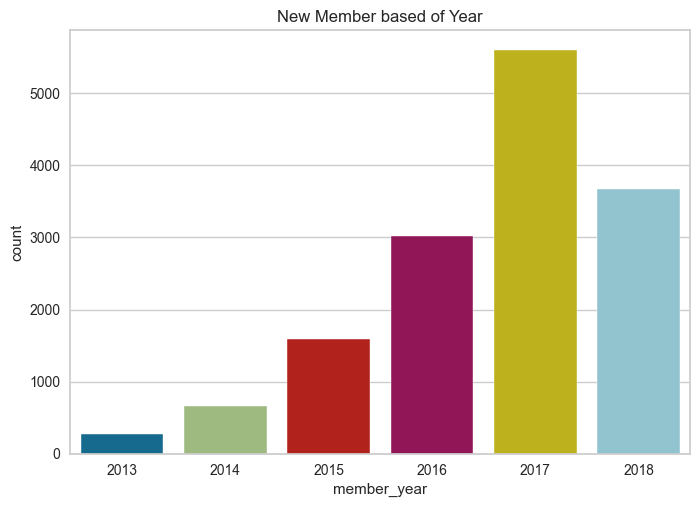

In [63]:
# 对"年"进行可视化分析
sns.countplot(data = data_customer2, x = 'member_year')
plt.title('New Member based of Year')

plt.show()

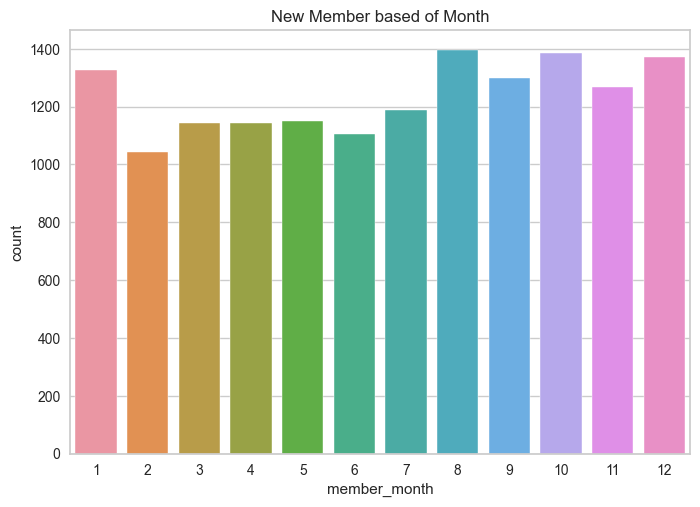

In [64]:
# 对"月"进行可视化分析
sns.countplot(data = data_customer2, x = 'member_month')

plt.title('New Member based of Month')

plt.show()

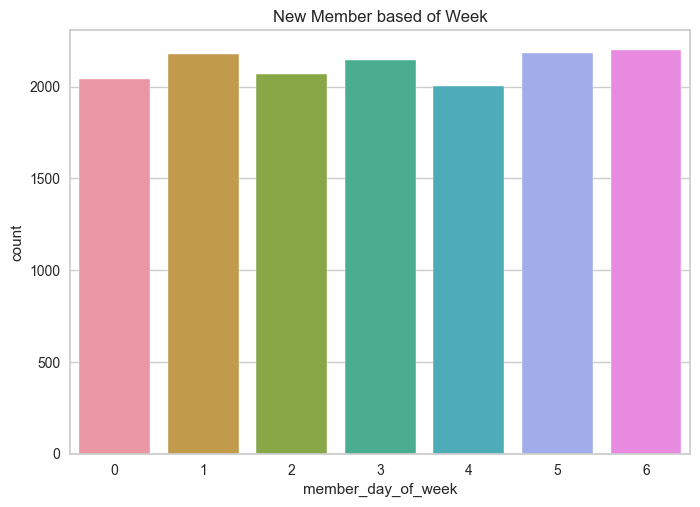

In [65]:
# 对"周"进行可视化分析
sns.countplot(data = data_customer2, x = 'member_day_of_week')

plt.title('New Member based of Week')

plt.show()

### 成为会员时间的观察结果：
1. 年：从2013-2017逐年增长，2017增长迅猛，但2018骤降。具体原因需要进一步分析，如使用PEST行业分析、多维度拆解分析等方法进行深入分析
2. 2-7月份新会员数量增长较少，8-1月份数量增长较多，可能与季节相关，得根据活动当地的实际情况进行分析
3. 工作日和周中的会员注册人数更高，猜测和目标客群多为需要工作的人居多有关。可考虑在周末增加活动力度，吸引新会员

## 4.2 对客户进行特征探索 -- 双变量解析 (Bivariate analysis)

### 4.2.1 新客户时间 - 性别

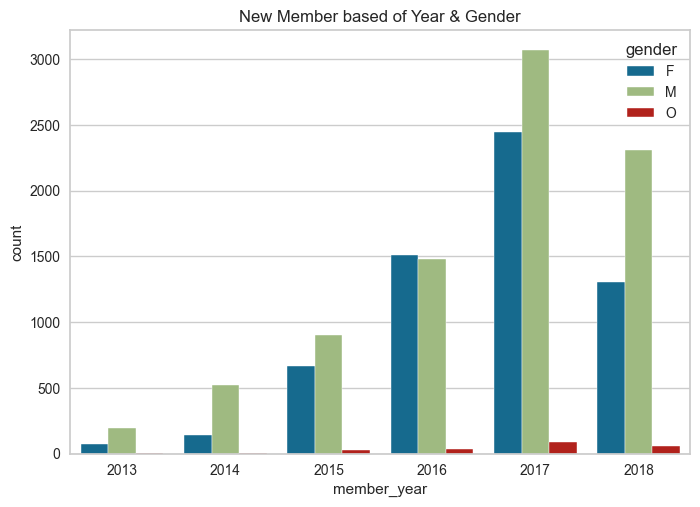

In [66]:
sns.countplot(data = data_customer2, x = 'member_year', hue='gender')

plt.title('New Member based of Year & Gender')

plt.show()

#### 每年新增的男性顾客都远多于女性顾客

### 4.2.2 年龄 - 性别

In [67]:
data_customer2.groupby('gender').agg({'age':'mean'})

,age
gender,
F,57.544950
M,52.116690
O,54.400943


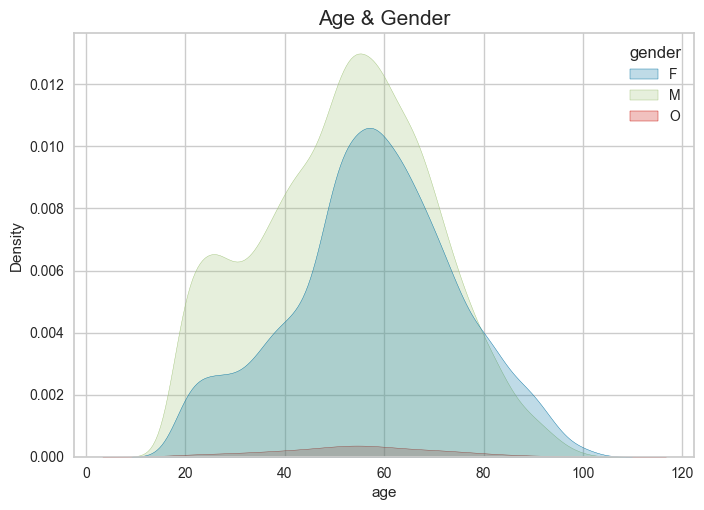

In [68]:
sns.kdeplot(data = data_customer2, x = 'age', hue = 'gender', fill = True)
plt.title('Age & Gender', fontsize = 15)

plt.show()

### 年龄 - 性别
1. 女性顾客较为符合正态分布
2. 男性顾客偏向年轻化

### 4.2.3 收入 - 性别

In [69]:
data_customer2.groupby('gender').agg({'income':'mean'})

,income
gender,
F,71306.412139
M,61194.601603
O,63287.735849


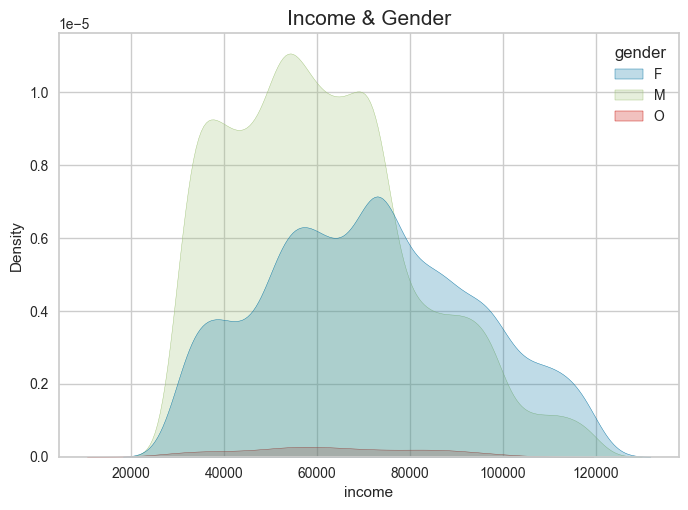

In [70]:
sns.kdeplot(data = data_customer2, x = 'income', hue = 'gender', fill = True)
plt.title('Income & Gender', fontsize = 15)

plt.show()

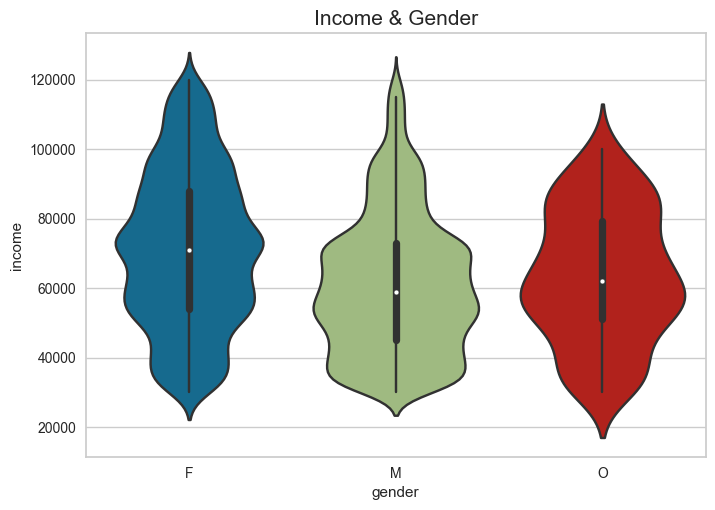

In [71]:
sns.violinplot(data = data_customer2, y = 'income', x = 'gender', fill = True)
plt.title('Income & Gender', fontsize = 15)

plt.show()

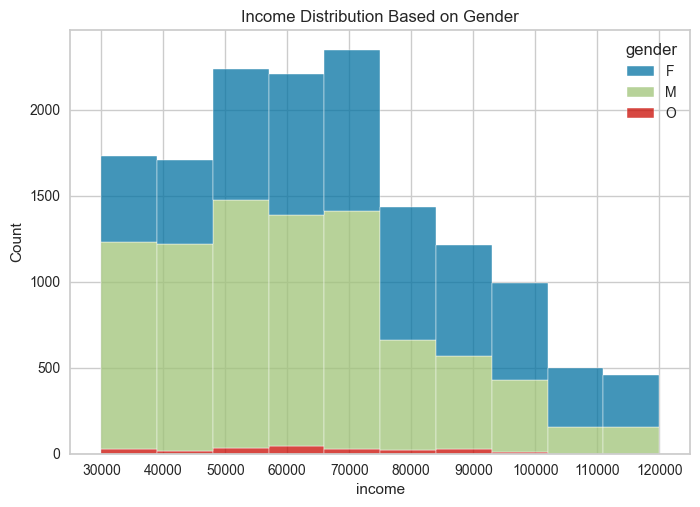

In [72]:
sns.histplot(data=data_customer2, x="income", hue="gender", multiple="stack", 
            bins=10);

bin_edges = np.arange(0, data_customer2['income'].max()+1, 10000)

plt.xticks(bin_edges)
plt.xlim(data_customer2.income.min()-5000, data_customer2.income.max()+5000)

plt.title('Income Distribution Based on Gender')

plt.show()

### 收入 - 性别
1. 在低收入范围，男性顾客远多于女性顾客；70K为分界线，高收入顾客男女数量相近
2. 女性顾客的收入差异更大
3. 女性总体平均收入更高

### 4.2.4 年龄 - 收入

In [73]:
data_customer2.groupby('age_group').agg({'income':'mean'})

,income
age_group,
18-25,50924.476797
26-35,51168.840580
36-45,59424.467558
46-55,69203.862661
56-65,70026.116004
66-75,70690.530131
>76,71707.692308


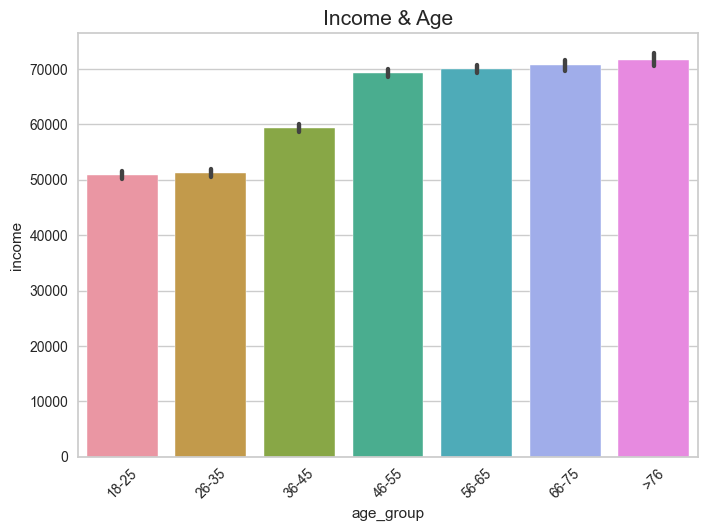

In [74]:
sns.barplot(data = data_customer2, x = 'age_group', y = 'income')

plt.xticks(rotation = 45)

plt.title('Income & Age', fontsize = 15)

plt.show()

<Axes: >

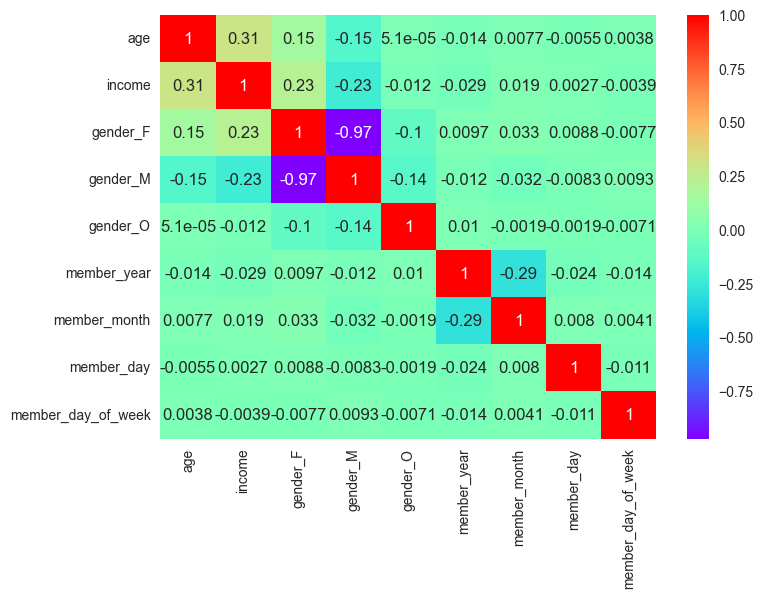

In [75]:
customer_related = data_customer2.select_dtypes(np.number)

sns.heatmap(customer_related.corr(), annot=True, cmap='rainbow')

### 年龄 - 收入
1. 年龄与收入呈正相关.年龄越大，收入越高

## 4.3 对活动情况进行特征探索

In [76]:
data_transcript2

,customer_id,event,hours_since_start,day_since_start,amount,offer_id,offer completed,offer received,offer viewed,transaction
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,0,0.00,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0,0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0,0.00,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0,0
2,e2127556f4f64592b11af22de27a7932,offer received,0,0,0.00,2906b810c7d4411798c6938adc9daaa5,0,1,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,0,0.00,fafdcd668e3743c1bb461111dcafc2a4,0,1,0,0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,0,0.00,4d5c57ea9a6940dd891ad53e9dbe8da0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,714,29,1.59,0,0,0,0,1
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,714,29,9.53,0,0,0,0,1
306531,a00058cf10334a308c68e7631c529907,transaction,714,29,3.61,0,0,0,0,1
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,714,29,3.53,0,0,0,0,1


In [77]:
data_transcript2['event'].value_counts()

event
transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: count, dtype: int64

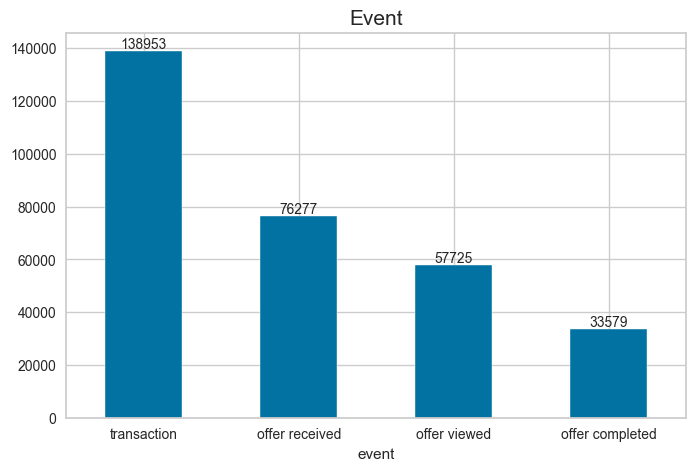

In [78]:
plt.figure(figsize = (8,5))

data_transcript2['event'].value_counts().plot(kind = 'bar')
plt.xticks(rotation = 0)
plt.title('Event', fontsize=15)

# 添加数值显示
counts = data_transcript2['event'].value_counts()  
ax = plt.gca()
heights = [rect.get_height() for rect in ax.patches]  

for rect, h, c in zip(ax.patches, heights, counts): 
    ax.text(rect.get_x() + rect.get_width() / 2, h + 0.5, c,
            ha='center', va='bottom', fontsize=10)

plt.show()

In [79]:
activity_stat = data_transcript2['event'].value_counts().to_dict()

print('交易总量：' + str(activity_stat['transaction']))
print('浏览率：' + str(round((activity_stat['offer viewed'] / activity_stat['offer received']), 2)))
print('完成率：' + str(round((activity_stat['offer completed'] / activity_stat['offer received']), 2)))
print('优惠活动交易占比：' + str(round((activity_stat['offer completed'] / activity_stat['transaction']), 2)))

交易总量：138953
浏览率：0.76
完成率：0.44
优惠活动交易占比：0.24


### 活动效果
1. 活动期间，交易总量：138953。
2. 76%的顾客浏览率，证明营销活动的设计很成功，吸引了绝大部分客户的参与
3. 44%的顾客完成了优惠活动交易
4. 优惠活动期间，使用了优惠的交易占比24%，说明很多客户即使没有优惠也在进行交易，体现良好的客户粘性

# 4.4 活动随着时间变化

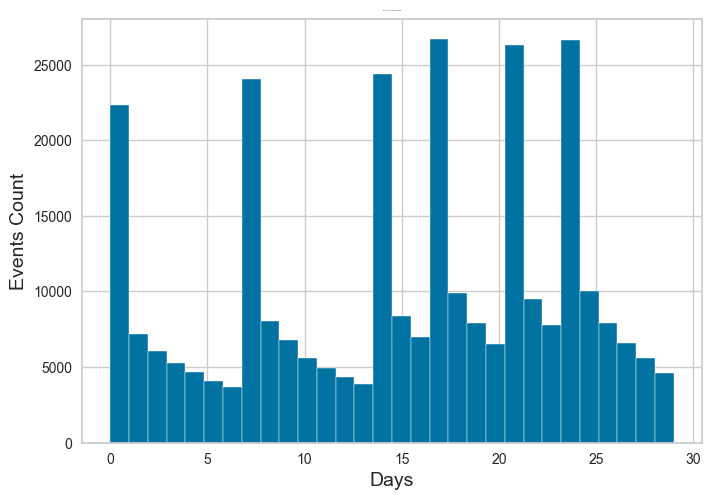

In [80]:
# 可视化活动随着时间变化的特征变化
plt.hist(data_transcript2['day_since_start'], bins = 30)

plt.xlabel('Days', fontsize = 14)
plt.ylabel('Events Count', fontsize = 14)
plt.title('Events Occurrence over time', fontsize = 1)

plt.show()

In [81]:
# 寻找活动推送的时间节点
data_transcript2[data_transcript2['event'] == 'offer received'].groupby('hours_since_start').count()

,customer_id,event,day_since_start,amount,offer_id,offer completed,offer received,offer viewed,transaction
hours_since_start,,,,,,,,,
0,12650,12650,12650,12650,12650,12650,12650,12650,12650
168,12669,12669,12669,12669,12669,12669,12669,12669,12669
336,12711,12711,12711,12711,12711,12711,12711,12711,12711
408,12778,12778,12778,12778,12778,12778,12778,12778,12778
504,12704,12704,12704,12704,12704,12704,12704,12704,12704
576,12765,12765,12765,12765,12765,12765,12765,12765,12765


In [82]:
data_transcript2[data_transcript2['event'] == 'offer received'].groupby('day_since_start').count()

,customer_id,event,hours_since_start,amount,offer_id,offer completed,offer received,offer viewed,transaction
day_since_start,,,,,,,,,
0,12650,12650,12650,12650,12650,12650,12650,12650,12650
7,12669,12669,12669,12669,12669,12669,12669,12669,12669
14,12711,12711,12711,12711,12711,12711,12711,12711,12711
17,12778,12778,12778,12778,12778,12778,12778,12778,12778
21,12704,12704,12704,12704,12704,12704,12704,12704,12704
24,12765,12765,12765,12765,12765,12765,12765,12765,12765


### 活动推送时间
1. 集中推送
2. 整个活动持续时间内，有明显6个事件高峰，对应六个特征类似的数值变化
3. 猜测活动期间共有六次活动推送，顾客随后发生了查看、消费、购买等活动
4. 才开始间隔约一周，活动后期每三天推送一次

In [83]:
# 计算客户三种活动的时间 -- 单位：小时
viewed_hourly = data_transcript2[data_transcript2['event'] == 'offer viewed'].value_counts('hours_since_start').sort_index()
completed_hourly = data_transcript2[data_transcript2['event'] == 'offer completed'].value_counts('hours_since_start').sort_index()
transaction_hourly = data_transcript2[data_transcript2['event'] == 'transaction'].value_counts('hours_since_start').sort_index()
print(len(viewed_hourly), len(completed_hourly), len(transaction_hourly))

# 计算客户三种活动的时间 -- 单位：天
viewed_daily = data_transcript2[data_transcript2['event'] == 'offer viewed'].value_counts('day_since_start').sort_index()
completed_daily = data_transcript2[data_transcript2['event'] == 'offer completed'].value_counts('day_since_start').sort_index()
transaction_daily = data_transcript2[data_transcript2['event'] == 'transaction'].value_counts('day_since_start').sort_index()
print(len(viewed_daily), len(completed_daily), len(transaction_daily))

120 120 120
30 30 30


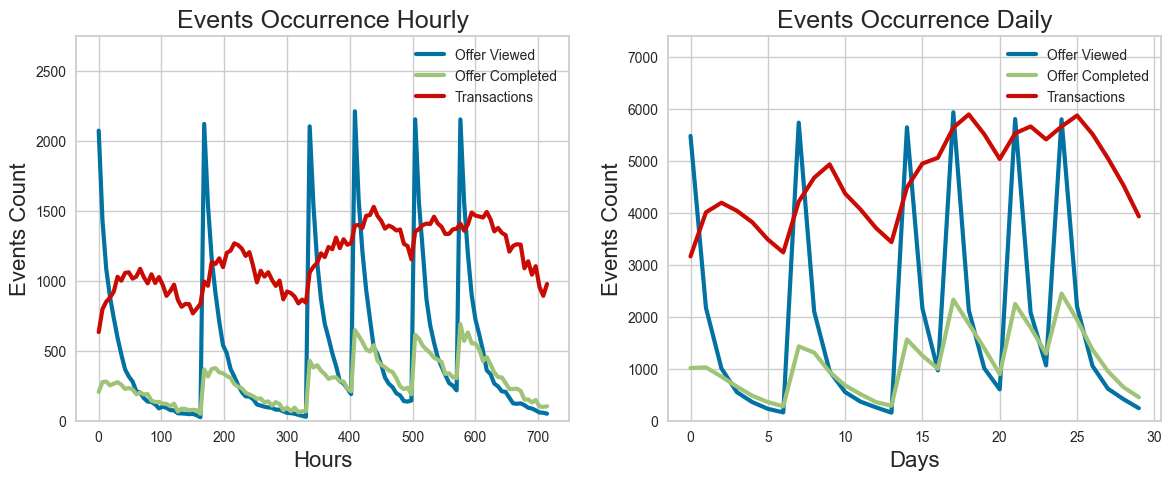

In [84]:
# 客户行为特征随着活动发生时间变化，可视化
hours = viewed_hourly.index.values

fig, axs = plt.subplots(1,2, figsize = (14, 5))

axs[0].plot(hours, viewed_hourly, lw = 3)
axs[0].plot(hours, completed_hourly, lw = 3)
axs[0].plot(hours, transaction_hourly, lw = 3)

axs[0].legend(['Offer Viewed', 'Offer Completed', 'Transactions'], loc = 'upper right', ncol = 1, fontsize = 10)

axs[0].set_ylim([0, 2750])

axs[0].set_xlabel('Hours', fontsize = 16)
axs[0].set_ylabel('Events Count', fontsize = 16)
axs[0].set_title('Events Occurrence Hourly', fontsize = 18)



days = np.arange(30)

axs[1].plot(days, viewed_daily, lw = 3)
axs[1].plot(days, completed_daily, lw = 3)
axs[1].plot(days, transaction_daily, lw = 3)

axs[1].legend(['Offer Viewed', 'Offer Completed', 'Transactions'], loc = 'upper right', ncol = 1, fontsize = 10)

axs[1].set_ylim([0, 7400])

axs[1].set_xlabel('Days', fontsize = 16)
axs[1].set_ylabel('Events Count', fontsize = 16)
axs[1].set_title('Events Occurrence Daily', fontsize = 18)

plt.show()

## 综上所述，活动情况：
1. 整个活动持续时间一个月
2. 共计主动推送了六次，前三次间隔约一周，后三次每三天推送，且推送时间都在一小时内完成
3. 每次推送之后，客户都会被唤醒，达到接收查看活动信息高峰，紧接着几小时内，达到活动使用消费高峰，证明大部分客户在接收优惠活动后当天便会使用
4. 活动期间的客户参与数量和交易数量均良好，且随着时间推移，交易量逐渐上升，证明此次活动设计很成功
5. 优惠活动不仅能带来短期消费的增加，而且提高了客户粘性，助于客户形成消费习惯；所以公司可以尝试以一定的频率对客户发送优惠

## 4.5 商家活动类型的探索

In [85]:
data_overall2.head(3)

,customer_id,offer_id,offer completed,offer received,offer viewed,offer successful,offer_name,reward,difficulty,duration,...,gender,age,income,gender_F,gender_M,gender_O,member_year,member_month,member_day,member_day_of_week
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1,1,0,0,C,2,10,7,...,M,33,72000.0,0,1,0,2017,4,21,4
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0,1,1,0,B,0,0,4,...,M,33,72000.0,0,1,0,2017,4,21,4
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0,1,1,0,A,0,0,3,...,M,33,72000.0,0,1,0,2017,4,21,4


In [86]:
data_overall2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55222 entries, 0 to 55221
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_id         55222 non-null  object 
 1   offer_id            55222 non-null  object 
 2   offer completed     55222 non-null  int64  
 3   offer received      55222 non-null  int64  
 4   offer viewed        55222 non-null  int64  
 5   offer successful    55222 non-null  int64  
 6   offer_name          55222 non-null  object 
 7   reward              55222 non-null  int64  
 8   difficulty          55222 non-null  int64  
 9   duration            55222 non-null  int64  
 10  web                 55222 non-null  int64  
 11  email               55222 non-null  int64  
 12  mobile              55222 non-null  int64  
 13  social              55222 non-null  int64  
 14  bogo                55222 non-null  int64  
 15  informational       55222 non-null  int64  
 16  disc

<Axes: >

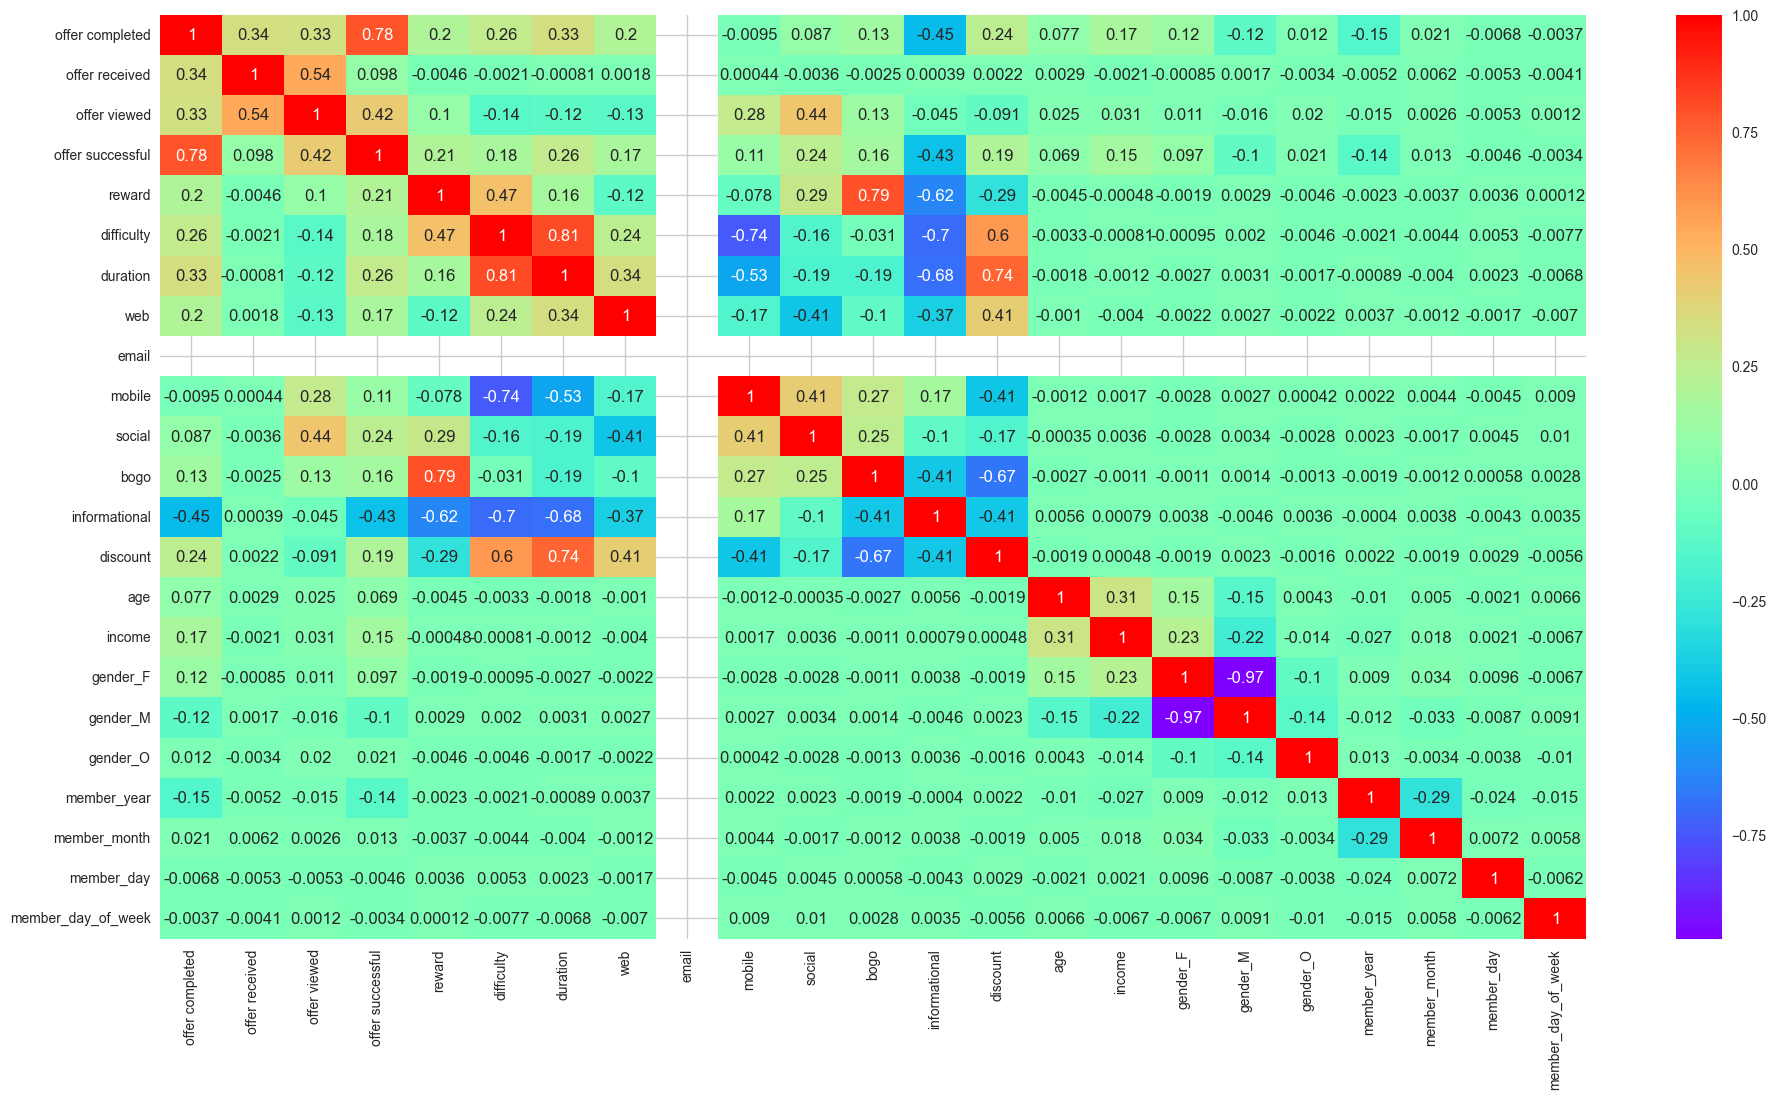

In [87]:
corr_overall = data_overall2.select_dtypes(np.number)


plt.figure(figsize=(23,12))

sns.heatmap(corr_overall.corr(), annot=True, cmap='rainbow')

In [88]:
# 活动类型
offer_type_list = offer_type.tolist()

# 每个类型的数量
for offer in offer_type_list:
    print(str(offer.upper()) +"'s type numbers: " + str(data_overall2[offer].sum()))

BOGO's type numbers: 22062
INFORMATIONAL's type numbers: 11041
DISCOUNT's type numbers: 22119


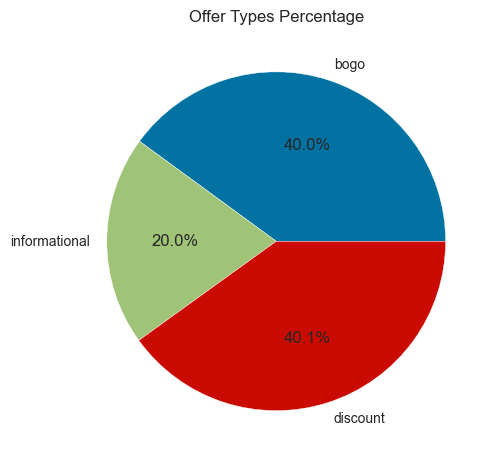

In [89]:
# 设置饼图的每个标签占比,占比对应data_overall2中每个类型的数量总和
sizes = []
for offer in offer_type_list:
    sizes.append(data_overall2[offer].sum())


# 绘制饼图
plt.pie(sizes, labels=offer_type_list, autopct='%1.1f%%')

# 设置饼图的标题
plt.title('Offer Types Percentage')

# 显示饼图
plt.show()

In [90]:
for offer in offer_type_list:
    df1 = data_overall2[offer] * data_overall2['offer received'] > 0
    df2 = data_overall2[offer] * data_overall2['offer viewed'] > 0
    df3 = data_overall2[offer] * data_overall2['offer successful'] > 0
        
    print(str(offer) + ': ')
    print("Viewed rate: " + str(round(df2.sum() / df1.sum(), 2)))
    print("Successful rate: " + str(round(df3.sum() / df1.sum(), 2)))
    print('\n')

bogo: 
Viewed rate: 0.85
Successful rate: 0.52


informational: 
Viewed rate: 0.73
Successful rate: 0.0


discount: 
Viewed rate: 0.71
Successful rate: 0.54




### 活动类型
1. 最受客户欢迎的活动是bogo，买一送一，85%的查看率以及52%的成功率
2. 信息类活动类型成功率为0，效果最差
3. 折扣类活动虽然查看率只有71%，但是完成率比bogo还高，达到了54%

### 十种具体的商家活动

In [91]:
for col in column_labels:
    df1 = data_overall2[data_overall2['offer_name'] == col]
    df2 = df1[df1['offer successful'] > 0]
    
        
    print(str(col) + "'s offer type successful rate: ")
    print(df2.shape[0])
    print('\n')

A's offer type successful rate: 
0


B's offer type successful rate: 
0


C's offer type successful rate: 
2335


D's offer type successful rate: 
4154


E's offer type successful rate: 
4062


F's offer type successful rate: 
3481


G's offer type successful rate: 
2397


H's offer type successful rate: 
1452


I's offer type successful rate: 
2805


J's offer type successful rate: 
2813




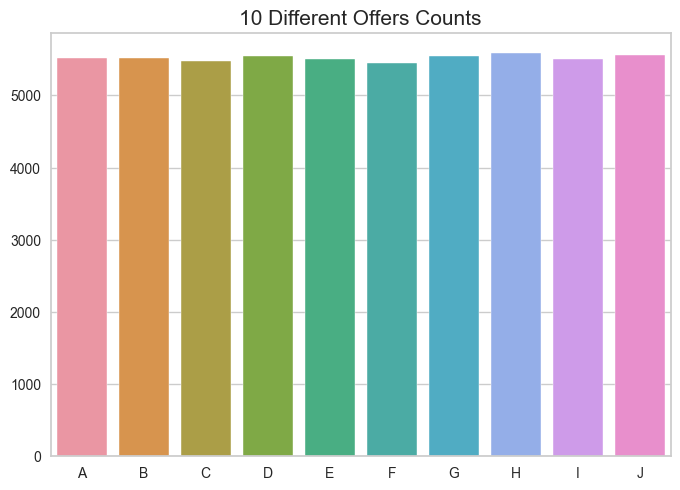

In [92]:
# 十种不同offer的发放数量对比
sizes = []
for col in column_labels:
    df1 = data_overall2[data_overall2['offer_name'] == col]
    df2 = df1[df1['offer received'] > 0]
    sizes.append(len(df2))
    
sns.barplot(x = column_labels, y = sizes)

plt.title('10 Different Offers Counts', fontsize = 15)

plt.show()

### 可以看出十种不同offer发放数量几乎一致

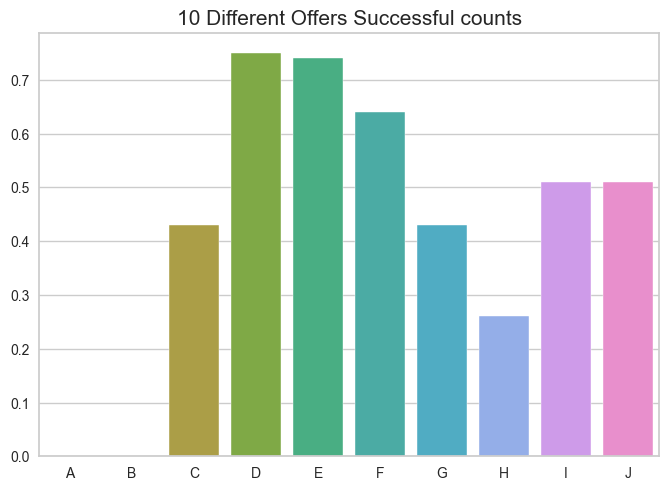

In [93]:
# 十种不同offer的成功使用率
sizes = []
for col in column_labels:
    df1 = data_overall2[data_overall2['offer_name'] == col]
    df2 = df1[df1['offer successful'] > 0]
    rate =len(df2) / len(df1)
    sizes.append(round(rate, 2))

sns.barplot(x = column_labels, y = sizes)

plt.title('10 Different Offers Successful counts', fontsize = 15)

plt.show()

### 十种活动成果
1. 在发放数量一致的情况下，活动D和E是成功率最高的活动，可以持续进行
2. 活动A和B成功率均为0，在以后的活动中要注意
3. 活动F、I、J位于第二梯队，活动成功率均超过50%，可以进行优化

## 4.6 商家活动推送途径的探索

In [94]:
# 每个推送途径的数量
for channel in all_channels:
    print(str(channel) +"'s numbers: " + str(data_overall2[channel].sum()))

web's numbers: 44141
email's numbers: 55222
mobile's numbers: 49634
social's numbers: 33088


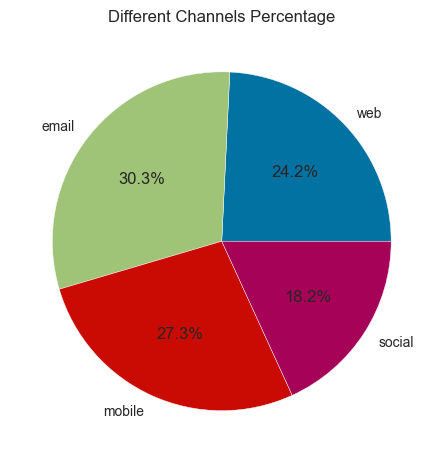

In [95]:
sizes = []
for channel in all_channels:
    sizes.append(data_overall2[channel].sum())


# 绘制饼图
plt.pie(sizes, labels=all_channels, autopct='%1.1f%%')

# 设置饼图的标题
plt.title('Different Channels Percentage')

# 显示饼图
plt.show()

In [96]:
for channel in all_channels:
    df1 = data_overall2[channel] * data_overall2['offer received'] > 0
    df2 = data_overall2[channel] * data_overall2['offer viewed'] > 0
    df3 = data_overall2[channel] * data_overall2['offer successful'] > 0
        
    print(str(channel) + ': ')
    print("Viewed rate: " + str(round(df2.sum() / df1.sum(), 2)))
    print("Successful rate: " + str(round(df3.sum() / df1.sum(), 2)))
    print('\n')

web: 
Viewed rate: 0.74
Successful rate: 0.47


email: 
Viewed rate: 0.77
Successful rate: 0.43


mobile: 
Viewed rate: 0.82
Successful rate: 0.44


social: 
Viewed rate: 0.95
Successful rate: 0.52




### 推送途径
1. 社交媒体 > 电子邮件 >= 手机 > 网站
2. social 途径有最高的查看率95%和完成率52%；当经费有限时，优先考虑social途径的活动推送
3. web完成率稍低，位于第二47%
4. email和mobile完成率几乎相同，但email查看之后的完成率更高

# 5 分类：预测

## 5.1 顾客是否会回应活动的预测

In [97]:
data_overall2.columns

Index(['customer_id', 'offer_id', 'offer completed', 'offer received',
       'offer viewed', 'offer successful', 'offer_name', 'reward',
       'difficulty', 'duration', 'web', 'email', 'mobile', 'social', 'bogo',
       'informational', 'discount', 'gender', 'age', 'income', 'gender_F',
       'gender_M', 'gender_O', 'member_year', 'member_month', 'member_day',
       'member_day_of_week'],
      dtype='object')

In [98]:
# 区分特征集和标签集
X = data_overall2.drop(['customer_id', 'offer_id', 'offer received', 'offer completed', 'offer viewed',
                        'offer successful', 'offer_name', 'gender', 'gender_O', 
                        'member_year', 'member_month', 'member_day', 'member_day_of_week'], axis=1)

y = data_overall2.loc[:, 'offer successful']

In [99]:
X.columns

Index(['reward', 'difficulty', 'duration', 'web', 'email', 'mobile', 'social',
       'bogo', 'informational', 'discount', 'age', 'income', 'gender_F',
       'gender_M'],
      dtype='object')

In [100]:
X_train,X_test,y_train,y_test =train_test_split(X, y, test_size=0.2, random_state=66)

<IPython.core.display.Javascript object>

### feature scaling

In [101]:
# 特征缩放到0-1之间的范围
trf1 = ColumnTransformer([('scale', MinMaxScaler(), X.columns)])

# 简单的逻辑回归模型
trf2 = LogisticRegression(solver='liblinear',random_state=66)

### fit model 交叉验证

In [102]:
# 机器学习流水线，按指定的顺序应用特征转换器和分类器
pipe = Pipeline([('trf1', trf1),('trf2', trf2),])

# 训练pipe
pipe.fit(X_train, y_train)


# 交叉验证cross_validate()方法评估模型的性能
scoring = ['accuracy', 'precision', 'recall']

cross_val = cross_validate(pipe, X, y, cv=10, scoring=scoring)

In [103]:
print("Accuracy:", cross_val['test_accuracy'])
print("Precision:", cross_val['test_precision'])
print("Recall:", cross_val['test_recall'])

Accuracy: [0.7361941  0.71881224 0.73198117 0.74339008 0.73705179 0.72564288
 0.72691054 0.73578414 0.74972836 0.73306773]
Precision: [0.68084245 0.66205775 0.67626775 0.6901753  0.68447001 0.67259198
 0.6728243  0.67970956 0.70284996 0.67965546]
Recall: [0.71531915 0.69276596 0.70966369 0.72042553 0.70893617 0.69234043
 0.69744681 0.71702128 0.71361702 0.70510638]


In [104]:
pipe.score(X_test, y_test)

0.7353553644182889

### 分类预测
通过商家的活动类型、推送途径；和客户的性别、年龄、收入等信息，模型有73.5%的准确度来预测，该顾客是否会参与该次活动

##  XGBoost预测

In [105]:
# 构建DMatrix对象
dtrain = xgb.DMatrix(X_train, label=y_train)

# 设置参数
param = {'max_depth': 3, 'eta': 0.1, 'objective': 'binary:logistic'}

# 训练模型
num_round = 10
bst = xgb.train(param, dtrain, num_round)

# 构建DMatrix对象
dtest = xgb.DMatrix(X_test)

# 预测
y_pred = bst.predict(dtest)

# 将预测概率转换为二元分类结果
y_pred = [1 if pred > 0.5 else 0 for pred in y_pred]

# 计算精度
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Accuracy: 0.7250339520144862


# 无监督聚类预测

In [106]:
# 保留数值列 特征
customer_cluster = data_overall2.drop(['customer_id', 'offer_id', 'offer_name', 'gender',
                                       'offer received', 'offer completed', 'offer viewed',
                                       'offer successful',  'gender_O', 'member_year', 'email',
                                       'member_month', 'member_day', 'member_day_of_week'], axis=1)


In [107]:
# 使用 StandardScaler 进行标准化处理，将数据转换为均值为 0、标准差为 1 的形式
scaler = StandardScaler()
scaler.fit(customer_cluster)

customer_cluster2 = pd.DataFrame(scaler.transform(customer_cluster),columns= customer_cluster.columns )
customer_cluster2

,reward,difficulty,duration,web,mobile,social,bogo,informational,discount,age,income,gender_F,gender_M
0,-0.648019,0.411225,0.222956,0.501035,0.335536,-1.222659,-0.815671,-0.499904,1.223351,-1.227533,0.305713,-0.838836,0.863161
1,-1.235862,-1.391249,-1.137195,0.501035,0.335536,-1.222659,-0.815671,2.000385,-0.817427,-1.227533,0.305713,-0.838836,0.863161
2,-1.235862,-1.391249,-1.590579,-1.995867,0.335536,0.817890,-0.815671,2.000385,-0.817427,-1.227533,0.305713,-0.838836,0.863161
3,0.233745,-0.490012,-0.683811,0.501035,0.335536,0.817890,1.225984,-0.499904,-0.817427,-1.227533,0.305713,-0.838836,0.863161
4,-0.648019,0.411225,1.583108,0.501035,0.335536,0.817890,-0.815671,-0.499904,1.223351,-1.227533,0.305713,-0.838836,0.863161
...,...,...,...,...,...,...,...,...,...,...,...,...,...
55217,0.233745,-0.490012,-0.683811,0.501035,0.335536,0.817890,1.225984,-0.499904,-0.817427,-1.170038,-1.451417,-0.838836,0.863161
55218,0.233745,2.213698,1.583108,0.501035,-2.980310,-1.222659,-0.815671,-0.499904,1.223351,-0.537584,-0.156690,1.192128,-1.158533
55219,-0.648019,0.411225,0.222956,0.501035,0.335536,-1.222659,-0.815671,-0.499904,1.223351,-0.537584,-0.156690,1.192128,-1.158533
55220,0.233745,-0.490012,0.222956,0.501035,0.335536,-1.222659,1.225984,-0.499904,-0.817427,-0.537584,-0.156690,1.192128,-1.158533


## 降维 PCA主成分分析

In [108]:
# 将原始数据进行降维，将特征的维度从原始数据的列数降低为3
pca = PCA(n_components=3)
pca.fit(customer_cluster2)

PCA_ds = pd.DataFrame(pca.transform(customer_cluster2), columns=(["col1","col2", "col3"]))

# 对降维后的数据框进行统计分析
PCA_ds.describe()

,col1,col2,col3
count,5.522200e+04,5.522200e+04,5.522200e+04
mean,2.502636e-17,3.589899e-17,-5.146809e-18
std,1.926757e+00,1.603150e+00,1.463130e+00
min,-3.282201e+00,-2.421136e+00,-2.169126e+00
25%,-9.662506e-01,-1.247734e+00,-1.291025e+00
50%,-2.098064e-01,-6.195426e-01,-6.649239e-01
75%,1.237502e+00,1.341308e+00,1.526861e+00
max,4.035064e+00,2.685168e+00,2.974846e+00


## Agglomerative clustering

### Elbow Method

Elbow Method to determine the number of clusters to be formed:


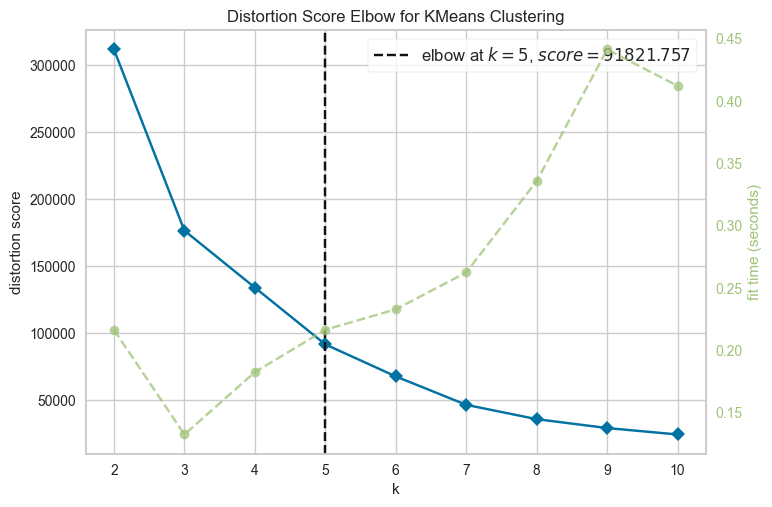

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [110]:
# 确定应该形成的聚类数目
print('Elbow Method to determine the number of clusters to be formed:')

Elbow_M = KElbowVisualizer(KMeans(), k=10)

Elbow_M.fit(PCA_ds)

Elbow_M.show()

### 使用Agglomerative Clustering算法进行聚类分析

In [ ]:
# # Agglomerative Clustering model
# AC = AgglomerativeClustering(n_clusters=5)

# # 拟合和预测，得到每个样本点的聚类标签
# yhat_AC = AC.fit_predict(PCA_ds)
# PCA_ds["Clusters"] = yhat_AC

# # 将聚类标签（yhat_AC）添加到原始数据集中，以便后续分析和可视化
# customer_cluster2["Clusters"]= yhat_AC

In [112]:
# # 聚类可视化
# fig = plt.figure(figsize=(12,8))

# ax = plt.subplot(111, projection='3d', label="bla")
# ax.scatter(x, y, z, s=40, c=customer_cluster2["Clusters"], marker='o', cmap = 'rainbow' )

# ax.set_title("The Plot Of The Clusters")

# plt.show()